# BPML - Final Submission
Dataset yang digunakan merupakan data penyakit tanaman tomat yang terdiri dari 8 kelas.

### Menentukan ukuran gambar

In [1]:
height = 128
width = 128
depth = 3

### menetukan directory data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
base_dir = '/content/drive/My Drive/dataset/tomato-desease'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
os.listdir(train_dir)

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']

### Membuat image data generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest'
)

### Load data

In [5]:
print('Data Training')
train_data = image_datagen.flow_from_directory(
    train_dir,
    target_size = (height,width),
    batch_size = 10,
    class_mode = 'binary'
)

print('Data Testing')
test_data = image_datagen.flow_from_directory(
    test_dir,
    target_size = (height,width),
    batch_size = 10,
    class_mode = 'binary'
)

Data Training
Found 10912 images belonging to 8 classes.
Data Testing
Found 2666 images belonging to 8 classes.


### Arsitektur Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

def cnn(input_shape):
    name = 'cnn'
    model = Sequential(name=name)
    model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(4,4))
    model.add(Dropout(0.25))
    model.add(Conv2D(16, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    model.add(Conv2D(16, (5,5), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (5,5), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(8, activation='sigmoid'))
    return model

In [7]:
input_shape = (height, width, depth)
model = cnn(input_shape)
model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 16)        2320    

### Compile Model

In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss= 'sparse_categorical_crossentropy', 
    optimizer= Adam(lr=1.000e-3, decay=1.000e-3 / 2),
    metrics= ['accuracy']
)

### Fitting model

In [9]:
num_epochs = 500
history = model.fit(
    train_data,
    steps_per_epoch=100,
    epochs=num_epochs,
    validation_data=test_data,
    validation_steps=10,
    verbose=1
)

Epoch 1/500
100/100 [==============================] - 7s 68ms/step - loss: 1.9505 - accuracy: 0.1940 - val_loss: 2.0463 - val_accuracy: 0.1500
Epoch 2/500
100/100 [==============================] - 7s 66ms/step - loss: 1.6931 - accuracy: 0.3629 - val_loss: 3.1550 - val_accuracy: 0.1800
Epoch 3/500
100/100 [==============================] - 7s 65ms/step - loss: 1.6007 - accuracy: 0.4090 - val_loss: 3.2166 - val_accuracy: 0.1700
Epoch 4/500
100/100 [==============================] - 6s 65ms/step - loss: 1.4008 - accuracy: 0.5000 - val_loss: 4.0389 - val_accuracy: 0.2500
Epoch 5/500
100/100 [==============================] - 6s 65ms/step - loss: 1.3651 - accuracy: 0.4930 - val_loss: 2.7071 - val_accuracy: 0.3800
Epoch 6/500
100/100 [==============================] - 6s 65ms/step - loss: 1.3716 - accuracy: 0.5110 - val_loss: 1.8462 - val_accuracy: 0.4100
Epoch 7/500
100/100 [==============================] - 7s 68ms/step - loss: 1.3121 - accuracy: 0.5200 - val_loss: 1.6203 - val_accuracy:

### Plot perubahan akurasi

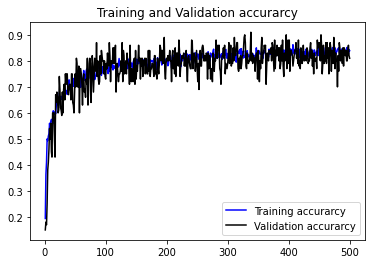

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'blue', label='Training accurarcy')
plt.plot(epochs, val_acc, 'black', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

### Menyimpan model dalam format .tflite

In [11]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp8v4_oisg/assets
